<a href="https://colab.research.google.com/github/prettyangell/alignement-des-s-quences-biologique/blob/main/mini_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation de l'Evironement

In [ ]:
!pip install blosum

In [ ]:
import blosum as bl
import random
import numpy as np
import csv
import os.path
import time
import pandas as pd
import matplotlib.pyplot as plt

blosum=bl.BLOSUM(62)

# Generating Data

In [ ]:
def generate_dna_sequence(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

def write_to_csv(filename, data):
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Seq1", "Seq2", "Length"])
        writer.writerows(data)

In [ ]:

lengths = [25, 50, 100, 200, 300, 500, 1000, 2000, 10000,20000]

for length in lengths:
      write_to_csv("dna_seq.csv", [[generate_dna_sequence(length), generate_dna_sequence(length), length]])

#Alignement par Paires

## Needleman-Wunsch

In [ ]:
def needleman_wunsch(seq1,seq2,indel,matrix):
  n,m=len(seq1),len(seq2)

  # Initialisation de la matrice des scores
  score_matrix = np.zeros((n+1, m+1))
  for j in range(m+1):
      score_matrix[j][0] = j * indel
  for i in range(n+1):
      score_matrix[0][i] = i * indel

  # Remplissage de la matrice des scores
  for i in range(1,n+1):
    for j in range(1,m+1):
      diag=score_matrix[i-1][j-1]+int(matrix[seq1[i-1]][seq2[j-1]])
      gauche=score_matrix[i][j-1]+indel
      haut=score_matrix[i-1][j]+indel
      score_matrix[i][j]=max(diag,gauche,haut)

  # Traceback : retrouver l'alignement optimal
  seq_al1=''
  seq_al2=''
  i,j=n,m

  while i>0 and j>0:
    score=score_matrix[i][j]
    # si la case provient de la diagonale
    if score==score_matrix[i-1][j-1] + int(matrix[seq1[i-1]][seq2[j-1]]):
      seq_al1+=seq1[i-1]
      seq_al2+=seq2[j-1]
      i-=1
      j-=1
    #si elle provient d'en haut
    elif score==score_matrix[i-1][j]+indel:
      seq_al1+=seq1[i-1]
      seq_al2+='-'
      i-=1
    # si elle provient d'a gauche
    else:
      seq_al2+=seq2[j-1]
      seq_al1+='-'
      j-=1
  while i > 0:
        seq_al1 += seq1[i-1]
        seq_al2 += '-'
        i -= 1
  while j > 0:
        seq_al1 += '-'
        seq_al2 += seq2[j-1]
        j -= 1
  return seq_al1[::-1], seq_al2[::-1], int(score_matrix[m][n])

Exemple d'utilisation

In [ ]:
seq1 = "NEALDLMAN"
seq2 = "NEEDLEMAN"

alignment = needleman_wunsch(seq1, seq2,-4,blosum)
print(f"Alignement:\n{alignment[0]}\n{alignment[1]}\nScore: {alignment[2]}")

Alignement:
NEALDL-MAN
NEE-DLEMAN
Score: 27


## Test sur des séquences d'ADN

In [ ]:
input_file="dna_seq.csv"
output_file="alignement.csv"
with open(input_file, mode='r') as file:
        reader = csv.DictReader(file)
        sequences = [(row['Seq1'], row['Seq2']) for row in reader]

    # Ouvrir le fichier CSV de sortie en mode écriture
with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Écrire l'en-tête
        writer.writerow(["Length","Sequence 1", "Sequence 2", "Aligned Sequence 1", "Aligned Sequence 2", "Score", "Execution Time (s)"])

        # Calculer l'alignement pour chaque paire de séquences
        for seq1, seq2 in sequences:
            start_time = time.time()
            align1, align2, score = needleman_wunsch(seq1, seq2,-2,blosum)
            end_time = time.time()
            execution_time = end_time - start_time
            # Écrire les résultats dans le fichier CSV
            writer.writerow([len(seq1),seq1, seq2, align1, align2, score, execution_time])

In [ ]:
data_frame=pd.read_csv("alignement.csv")
data_frame[['Length', 'Score', 'Execution Time (s)']]

,Length,Score,Execution Time (s)
0,25,53,0.002244
1,50,112,0.009681
2,100,276,0.019840
3,200,622,0.078775
4,300,897,0.195037
5,500,1554,0.523571
6,1000,3180,3.426914
7,2000,6185,8.741714
8,10000,31302,247.360532
9,20000,62846,976.053547


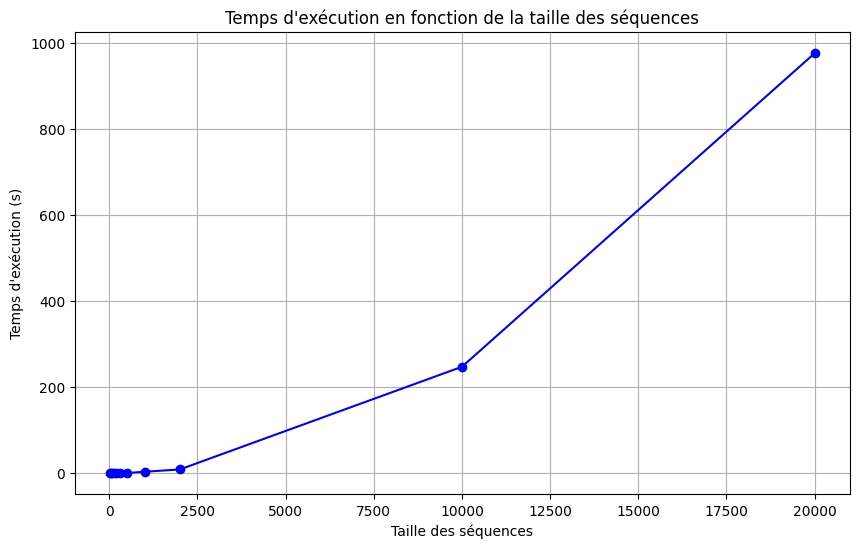

In [ ]:
sizes = data_frame['Length']
execution_times = data_frame['Execution Time (s)']

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(sizes, execution_times, marker='o', linestyle='-', color='b')
plt.xlabel('Taille des séquences')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille des séquences')
plt.grid(True)
plt.show()


# Alignement Multiple

In [ ]:

from itertools import combinations


# Fonction pour calculer la distance de Hamming entre deux séquences
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Fonction pour créer une matrice de distance qui va nous permettre de reconettre les deux premiere séqunce qui ont le meilleur alignement
def create_distance_matrix(sequences):
    num_seqs = len(sequences)
    matrix = np.zeros((num_seqs, num_seqs))
    for i, j in combinations(range(num_seqs), 2):
      #on utilise la distane de hamming
        dist = hamming_distance(sequences[i], sequences[j])
        matrix[i, j] = dist
        matrix[j, i] = dist
    return matrix

# Fonction pour aligner deux séquences
def align_pair(seq1, seq2):
    m, n = len(seq1), len(seq2)
    # Initialise la matrice de score
    score = np.zeros((m + 1, n + 1))
    for i in range(m + 1):
        score[i][0] = -i
    for j in range(n + 1):
        score[0][j] = -j

    # Remplir la matrice de score
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + (1 if seq1[i - 1] == seq2[j - 1] else -1)
            delete = score[i - 1][j] - 1
            insert = score[i][j - 1] - 1
            score[i][j] = max(match, delete, insert)

    # Traceback pour obtenir l'alignement
    align1, align2 = "", ""
    i, j = m, n
    while i > 0 or j > 0:
        current_score = score[i][j]
        if i > 0 and j > 0 and current_score == score[i - 1][j - 1] + (1 if seq1[i - 1] == seq2[j - 1] else -1):
            align1 = seq1[i - 1] + align1
            align2 = seq2[j - 1] + align2
            i -= 1
            j -= 1
        elif i > 0 and current_score == score[i - 1][j] - 1:
            align1 = seq1[i - 1] + align1
            align2 = "-" + align2
            i -= 1
        else:
            align1 = "-" + align1
            align2 = seq2[j - 1] + align2
            j -= 1

    return align1, align2

def progressive_alignment(sequences):
    if len(sequences) == 1:
        return sequences

    distance_matrix = create_distance_matrix(sequences)
    print("Matrice de distance:\n", distance_matrix)

    # on trie la matrice de distance pour les executer par ordre de match
    sorted_indices = np.argsort(np.sum(distance_matrix, axis=0))
    sorted_sequences = [sequences[i] for i in sorted_indices]

    profile = [sorted_sequences[0]]
    alignments = [sorted_sequences[0]]
    for seq in sorted_sequences[1:]:
        new_profile = []
        for profile_seq in profile:
            aligned_profile, aligned_seq = align_pair(profile_seq, seq)
            new_profile.append(aligned_profile)
            new_profile.append(aligned_seq)
        profile = new_profile
        alignments = profile.copy()

    return alignments

In [ ]:
# Séquences d'exemple
sequences = [
    "AGGCT",
    "AGGCA",
    "AGGTA"
]

# Créer la matrice de distance
distance_matrix = create_distance_matrix(sequences)
print("Matrice de distance:\n", distance_matrix)

# Aligner les séquences progressivement selon l'arbre guide ((Seq1, Seq2), Seq3), Seq4)
aligned_seq1, aligned_seq2 = align_pair(sequences[0], sequences[1])
print("\nAlignement Seq1 et Seq2:")
print(aligned_seq1)
print(aligned_seq2)

profile1 = (aligned_seq1, aligned_seq2)
aligned_seq3, profile1 = align_pair("".join(profile1[0]), sequences[2])
print("\nAlignement du profil avec Seq3:")
print(aligned_seq3)
print(profile1)



Matrice de distance:
 [[0. 1. 2.]
 [1. 0. 1.]
 [2. 1. 0.]]

Alignement Seq1 et Seq2:
AGGCT
AGGCA

Alignement du profil avec Seq3:
AGGCT-
AGG-TA


In [ ]:
# Générer des séquences ADN de longueur fixe
L = 50
max_sequences = 10
execution_times = []
num_sequences_list = list(range(3, max_sequences + 1))

for num_sequences in num_sequences_list:
    sequences = [generate_dna_sequence(L) for _ in range(num_sequences)]
    start_time = time.time()
    alignment = progressive_alignment(sequences) #générer des séquences ADN de longueur fixe
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)

    print(f"\nAlignement pour {num_sequences} séquences:")
    for seq in alignment:
        print(seq)


Matrice de distance:
 [[ 0. 40. 39.]
 [40.  0. 38.]
 [39. 38.  0.]]

Alignement pour 3 séquences:
T--TGATTA-TTTTA---CTGG-AT-ACCACTGTCCATGGGAG-C-ACTCTAGGATAT-T--C---
-----A-TACGTGT----GTCG--T---CTCTGT-TAAAGGAGTAAAATCTAACATATCTAACTAA
-TCCAG-GTG-CG--TC-G--AGGGGGGGCATCACC-C-G---A-GAGAGTCGCCTCTTGGA-A--C
ATAC-GTGTGTCGTCTCTGTTA-AAGGAG--TAAAATC----TAACATA-TC-TAAC-T--A-A---
Matrice de distance:
 [[ 0. 42. 39. 35.]
 [42.  0. 39. 29.]
 [39. 39.  0. 38.]
 [35. 29. 38.  0.]]

Alignement pour 4 séquences:
-AGCT-GCTA-CC---GC-GTTCCTCA-GG-A--CA-GCGACCCA-GT-TC-CGTCATGG-GTGTT
AAAC-CG-TA--C-AGGCATTTCCCCA-CGTACTCATAC-ACCC-----TC-AATC--GGCGTG-T
--ACC-T---GGC-T--TC-GTG-TGGA-GATGAGGGT-AGTA-CTA-CCA--TCTC-C-T-ATAC--CAG--T
AAACCGTACAGGCAT--T---T-CCCCACG-T-A--CTCA-TA-C-A-CC----CT--C--AAT-CGGC-GTGT
TA-CT---TATCCA-AAACTGCTCCAC--A--CA---T-CAGC-ACTCACG--CGCG--A-AGGATGCC
AAAC--CGTA--CAGGCATTTCCCCACGTACTCA---TACA-C-CCTCA--ATCG-G-----CG-TG-T
--ACC-T---GGC-T-T-C----GTG-TGGA-GATGAGGGT-AG-TACT-ACCATCTC-CTATAC--CA-G-T
AAACC

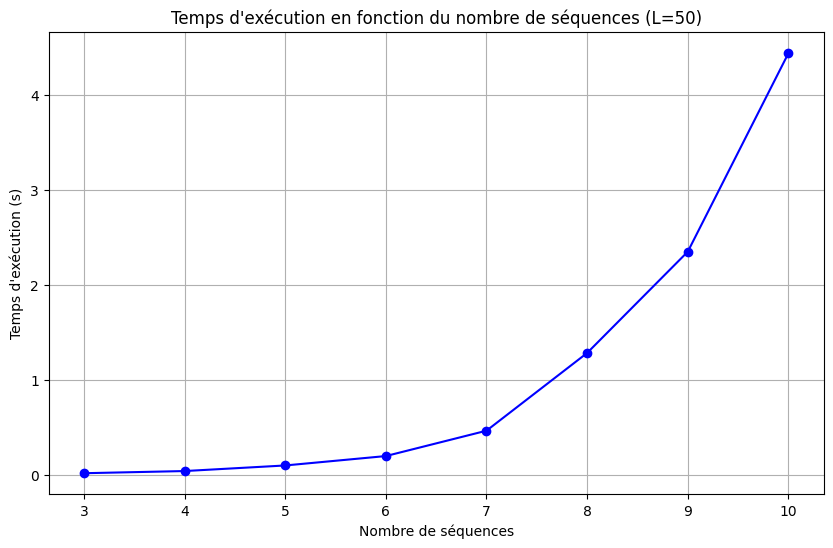

In [ ]:
# Tracer le temps d'exécution en fonction du nombre de séquences
plt.figure(figsize=(10, 6))
plt.plot(num_sequences_list, execution_times, marker='o', linestyle='-', color='b')
plt.xlabel('Nombre de séquences')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction du nombre de séquences (L=50)')
plt.grid(True)
plt.show()

Matrice de distance:
 [[ 0. 72. 82. 74. 77.]
 [72.  0. 68. 71. 75.]
 [82. 68.  0. 82. 80.]
 [74. 71. 82.  0. 78.]
 [77. 75. 80. 78.  0.]]

Alignement pour des séquences de longueur 100:
séquence 2: ------G-G-GGC--CCTGT--ATG-GTCCATAGT-GCCTGAA-AATG-GGA-A-GTGAAGG-CGATTCAGC-C-GAGTTTG--A--GC--TGTTA-A--G-CC---T-GTGGGTGACAACTGCCGCGGC-GT--CG-C-
séquence 3: --------TAGG--TCAGGT---GGAGT--ATAG--G-CTGTA-TAT-ACG-TATTTG-CTG--GA-TAATCGGAGAATTTCCGA--G---AGGTA-ACAG-GC---TGGTTGTTG-C--CT-CCAC-GCAGTGGAGACT
séquence 5: -AATTCTAG-AG--ACGG-GT---TGCT-TCCCCA---GCCTG-ACG-A---GC-GGA-CA-CG-CAACAAAGCTT--GC-CTG-CCTTG-----TC---GTGAGA--G-TC---T-AT-GGAAAT-AA-TG-AGTGTCG-GT-G-G
séquence 3: TAGGTC-AG--G---TGGAGTATAGGCTGT----A------TATACGTATTTGCTGGATAATCG--GA-GAA--TT------T--CC--G------AGAGGT-A-ACAG-GCTGGTTGT-TG-CCTCCA-CGCAGTG--GAG--ACT
séquence 4: -A---CTGGT-GTGA--GGCT-GCCTCCGCAT--T-TGTA-GT-G-CTG----A--GGCA-G-GAA---C-AATC--CTCTAG---GG-GAC-GGC--GATGATAGACCGCC-CGG--ATAGTGGGTG------G-C-C-GC-TCGCA
séquence 3: TAGGTCAGGT-G-GA

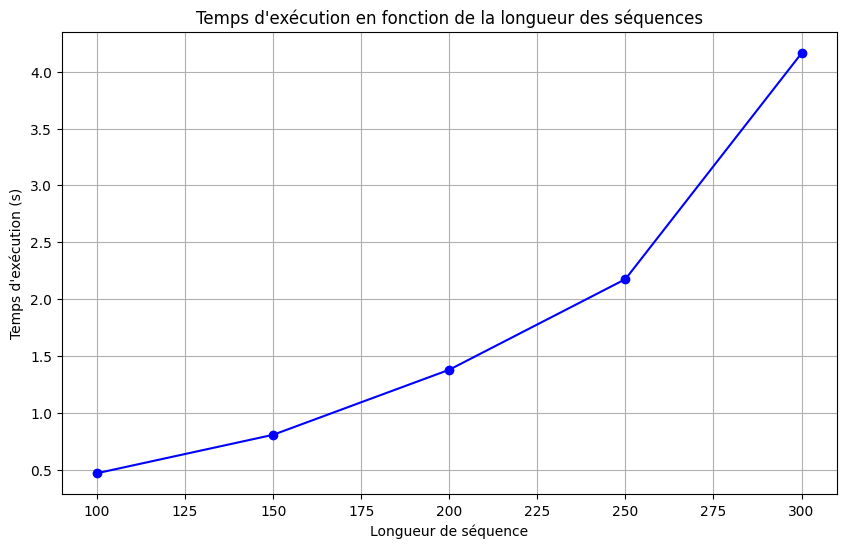

In [ ]:
def progressive_alignment(sequences, names):
    if len(sequences) == 1:
        return sequences, names

    distance_matrix = create_distance_matrix(sequences)
    print("Matrice de distance:\n", distance_matrix)

    # Pour simplifier, nous utilisons un arbre guide simple basé sur les distances
    sorted_indices = np.argsort(np.sum(distance_matrix, axis=0))
    sorted_sequences = [sequences[i] for i in sorted_indices]
    sorted_names = [names[i] for i in sorted_indices]

    profile = [sorted_sequences[0]]
    profile_names = [sorted_names[0]]
    alignments = [(sorted_sequences[0], sorted_names[0])]

    for seq, name in zip(sorted_sequences[1:], sorted_names[1:]):
        new_profile = []
        new_profile_names = []
        for profile_seq, profile_name in zip(profile, profile_names):
            aligned_profile, aligned_seq = align_pair(profile_seq, seq)
            new_profile.append(aligned_profile)
            new_profile_names.append(profile_name)
            new_profile.append(aligned_seq)
            new_profile_names.append(name)
        profile = new_profile
        profile_names = new_profile_names
        alignments = list(zip(profile, profile_names))

    return alignments
# Générer des séquences ADN de différentes tailles
sequence_lengths = [100, 150, 200, 250, 300]
num_sequences = 5  # Fixer le nombre de séquences à 5 pour chaque test

results = []

for L in sequence_lengths:
    sequences = [generate_dna_sequence(L) for _ in range(num_sequences)]
    names = [f"séquence {i+1}" for i in range(num_sequences)]
    start_time = time.time()
    alignment = progressive_alignment(sequences, names)
    end_time = time.time()

    execution_time = end_time - start_time
    results.append([L, execution_time])

    print(f"\nAlignement pour des séquences de longueur {L}:")
    for seq, name in alignment:
        print(f"{name}: {seq}")

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=['Longueur de séquence', 'Temps d\'exécution (s)'])

# Afficher les résultats
print("\nRésultats des tests:")
print(df_results)

# Tracer le temps d'exécution en fonction de la longueur des séquences
plt.figure(figsize=(10, 6))
plt.plot(df_results['Longueur de séquence'], df_results['Temps d\'exécution (s)'], marker='o', linestyle='-', color='b')
plt.xlabel('Longueur de séquence')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la longueur des séquences')
plt.grid(True)
plt.show()

In [ ]:
df_results

,Longueur de séquence,Temps d'exécution (s)
0,100,0.468381
1,150,0.806370
2,200,1.378557
3,250,2.175323
4,300,4.162269
